# Machine learning the wavefunction
The solution of the 1d Schrödinger equation is learned by a neural network. The training set consists of randomly generated potentials, which are built as superposition of Gaussians of the form

$$
        V(x) = \sum_i^5 G(A_i,\sigma_i,\mu_i,x)
$$

with randomly values chosen $A_i,\sigma_i,\mu_i$ for the amplitude, width, and mean, respectively. The target property is the first excited state $|\Psi_1(x)|^2$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gaussian(a, m, sigma, x):
    return a*np.exp(-((x-m)/sigma)**2)

In [3]:
def gaussian_superposition(a, m, sigma, x):
    potential = 0.
    potential = -sum(gaussian(ai, mi, si, x) for ai, mi, si in zip(a,m, sigma))
    return potential


### Example random potentials

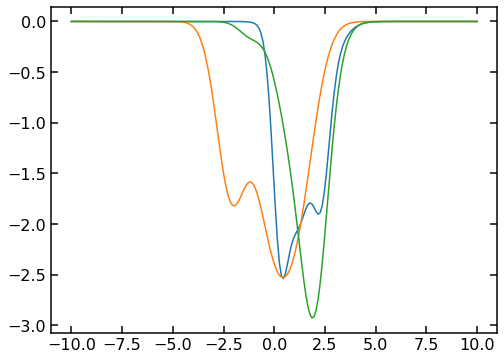

In [4]:
import matplotlib.pyplot as plt
plt.style.use('scientific.mplstyle')
plt.figure(figsize=(8,6))
x = np.linspace(-10,10,200)
n_examples = 3
n_gaussians = 5


for i in range(n_examples):
    a = 2*np.random.random(n_gaussians)
    m = 5*np.random.random(n_gaussians) - 2.5
    sigma = np.random.random(n_gaussians) + .5
    y = gaussian_superposition(a, m, sigma, x)
    plt.plot(x, y)

### Example solutions for random potentials

In [5]:
from _ham import Hamiltonian

In [6]:
# Inititalize Hamiltonian
length = 15
n_steps = 201
ham_random  = Hamiltonian(length,n_steps)

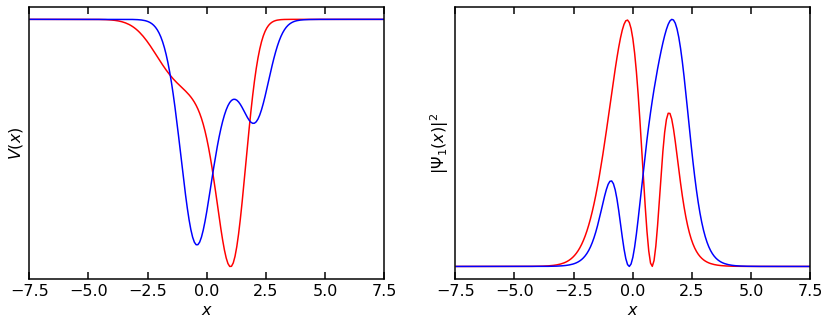

In [7]:
import matplotlib.pyplot as plt
plt.style.use('scientific.mplstyle')
fig, ax = plt.subplots(1,2,figsize=(14,5))

colors = ['red', 'blue', 'green']

n_data = 3

X_plot = np.zeros((n_data, n_steps))
y_plot = np.zeros((n_data,n_steps))

n_gaussians = 5

for i in range(2):
    a = 2*np.random.random(n_gaussians)
    m = 5*np.random.random(n_gaussians) - 2.5
    sigma = np.random.random(n_gaussians) + .5


    potential = lambda x: gaussian_superposition(a, m, sigma, x)
    ham_random.build_hamiltonian(potential)
    ham_random.diagonalize()

    X_plot[i, :] = potential(ham_random.x_values)
    y_plot[i,:] = ham_random.eigvecs[:,1]**2

    # plt.plot(ham_random.x_values, ham_random.eigvecs[:,1]**2, color=colors[i])

    ax[0].plot(ham_random.x_values, potential(ham_random.x_values),
            color=colors[i])
    ax[1].plot(ham_random.x_values, y_plot[i,:], color=colors[i])

ax[0].set_xlabel('$x$')
ax[1].set_xlabel('$x$')
ax[0].set_ylabel('$V(x)$')
ax[1].set_ylabel(r'$|\Psi_1(x)|^2$')

ax[0].set_yticks([])
ax[1].set_yticks([])

ax[0].set_xlim(-7.5,7.5)
ax[1].set_xlim(-7.5,7.5)

# fig.savefig('randompot.png',dpi=fig.dpi)

plt.show()


### Example solution for one Gaussian. Solutions positioned to the corresponding energy values.

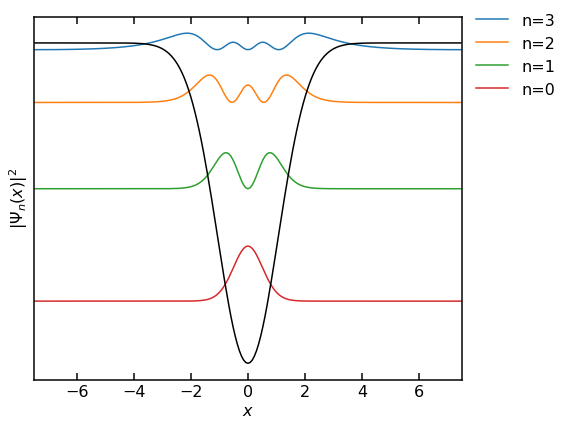

In [8]:
#Solving for simple Gaussian potential
import matplotlib.pyplot as plt
plt.style.use('scientific.mplstyle')
fig = plt.figure(figsize=(8,6))

a = 5
m = 0
sigma = 1.5


potential = lambda x: -gaussian(a, m, sigma, x)
ham_random.build_hamiltonian(potential)
ham_random.diagonalize()

X_plot = potential(ham_random.x_values)
y_plot = ham_random.eigvals[0]

for i in reversed(range(4)):
    plt.plot( ham_random.x_values,ham_random.eigvals[i]+15*ham_random.eigvecs[:,i]**2, label =f'n={i}')
# plt.plot(ham_ws.x_values,ham_ws.eigvecs[:,0]**2)
# plt.plot(ham_ws.x_values,ham_ws.eigvals[2] + ham_ws.eigvecs[:,2]**2)
plt.plot(ham_random.x_values,potential(ham_random.x_values), color='black')


plt.xlabel('$x$')
plt.ylabel(r'$|\Psi_n(x)|^2$')
plt.legend(bbox_to_anchor=(1., 1.05))
plt.yticks([])
plt.xlim(-7.5,7.5)
plt.tight_layout()
plt.show()
# fig.savefig('gaussian.png',dpi=fig.dpi)

### Create dataset
10000 random potentials are created, for which the Schrödinger equation is solved.

In [144]:
n_gaussians = 5

n_data = 10000

potentials = np.zeros((n_data, n_steps))
eigvecs = np.zeros((n_data, n_steps))
eigvals = np.zeros((n_data, 1))

for i in range(n_data):
    a = 2*np.random.random(n_gaussians)
    m = 5*np.random.random(n_gaussians) - 2.5
    sigma = np.random.random(n_gaussians) + .5

    potential = lambda x: gaussian_superposition(a, m, sigma, x)
    ham_random.build_hamiltonian(potential)
    ham_random.diagonalize()

    potentials[i, :] = potential(ham_random.x_values)
    eigvecs[i, :] = np.absolute(ham_random.eigvecs[:,1])**2
    eigvals[i] = ham_random.eigvals[1]

/tmp/ipykernel_4748/526239296.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  eigvals[i] = ham_random.eigvals[1]


In [146]:
data_eigvecs = np.stack((potentials, eigvecs))
data_eigvals = np.append(potentials, eigvals, axis=1)


np.save('data_eigvecs.npy',data_eigvecs)   
np.save('data_eigvals.npy',data_eigvals)   

data_eigvecs.shape, data_eigvals.shape



((2, 10000, 201), (10000, 202))

### Build a DataLoader for training and test data

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [115]:
data_load = np.load('data_eigvecs.npy')

X = data_load[0,:,:]
y = data_load[1,:,:]

train_fraction = 0.8


tensor_x = torch.Tensor(X)
tensor_y = torch.Tensor(y)

train_size = int(train_fraction*len(tensor_x))

test_size = len(tensor_x) - train_size


norm_x = 10
norm_y = torch.max(tensor_y).item()

dataset_train = TensorDataset(tensor_x[:train_size, :] / norm_x,
                            tensor_y[:train_size] ) 
dataloader_train = DataLoader(dataset_train, batch_size=120) 

dataset_test = TensorDataset(tensor_x[train_size:, :] / norm_x ,
                            tensor_y[train_size:] ) 
dataloader_test = DataLoader(dataset_test) 


### Build and train MLP model

In [144]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class MLP(nn.Module):
        def __init__(self, n_steps):
            super().__init__()
            self.layer1 = nn.Linear(n_steps, n_steps)
            self.layer2 = nn.Linear(n_steps, n_steps)
            self.layer3 = nn.Linear(n_steps, n_steps)
            self.layer4 = nn.Linear(n_steps, n_steps)
            self.layer5 = nn.Linear(n_steps, n_steps)
            self.layer6 = nn.Linear(n_steps, n_steps)

        def forward(self, x):
            x = F.relu( self.layer1(x) )
            x = F.relu( self.layer2(x) )
            x = F.relu( self.layer3(x) )
            x = F.relu( self.layer4(x) )
            x = F.relu( self.layer5(x) )
            x =  self.layer6(x) 
            return x

In [145]:
model = MLP(n_steps)
optimizer = optim.Adam(model.parameters(), lr=0.005)
loss_function = nn.MSELoss()


In [146]:
all_losses = []
n_epochs = 50
for epoch in range(n_epochs):
    running_loss = 0.0

    for i, (potential, wavefunction) in enumerate(dataloader_train):

        # Forward pass
        outputs = model(potential)
        loss = loss_function(outputs, wavefunction)
        running_loss += loss.item()
        
        # Propagate backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    all_losses.append(running_loss / len(dataloader_train))
    if epoch  % 10 == 0:
            print ('Epoch [{}/{}],  Loss: {:.4e}' 
                .format(epoch+1, n_epochs,all_losses[epoch]))

Epoch [1/50],  Loss: 1.0965e-04
Epoch [11/50],  Loss: 2.5007e-06
Epoch [21/50],  Loss: 1.3714e-06
Epoch [31/50],  Loss: 1.4291e-06
Epoch [41/50],  Loss: 6.9932e-07


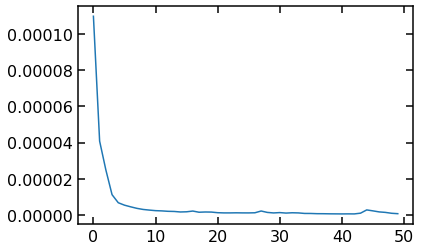

In [147]:
plt.plot(all_losses)
plt.show()

### Evaluate model

In [148]:
mae = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(dataloader_test):
        potential, energy = data
        output = model(potential)
        i += 1
        mae += torch.mean(torch.abs(output - energy))



print(f'mae of the network on the test examples: {mae / len(dataloader_test)}')


mae of the network on the test examples: 0.0005539785488508642


### Two examples of randomly chose smaples of the test set

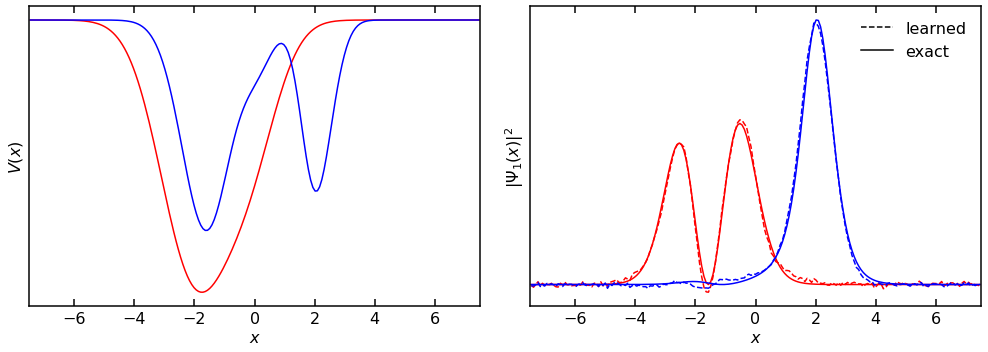

In [150]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0],linestyle='dashed', color='black'), Line2D([0], [0], color='black')]

plt.style.use('scientific.mplstyle')
fig, ax = plt.subplots(ncols=2,figsize=(14,5))

colors = ['red', 'blue', 'green']
model.float()


for i in range(2):
    sample = train_size + int((test_size-1)*np.random.rand())
    with torch.no_grad():
        y_pred = model(tensor_x[sample] / norm_x)
    
    ax[1].plot(ham_random.x_values, y_pred, color=colors[i], linestyle='dashed' , label='learned' if i == 0 else '')
    ax[1].plot(ham_random.x_values, tensor_y[sample], color=colors[i],label='exact' if i == 0 else '')
    ax[0].plot(ham_random.x_values, tensor_x[sample]/ 20, color=colors[i] )

ax[0].set_yticks([])
ax[1].set_yticks([])

ax[0].set_xlabel('$x$')
ax[1].set_xlabel('$x$')
ax[0].set_ylabel('$V(x)$')
ax[1].set_ylabel(r'$|\Psi_1(x)|^2$')
ax[0].set_xlim(-7.5,7.5)
ax[1].set_xlim(-7.5,7.5)


# plt.ylim(0,10)
# plt.xlim(-8,8)
plt.tight_layout()
leg = ax[1].get_legend()

plt.legend(custom_lines, ['learned','exact'])

plt.show()
# fig.savefig('learn.png',dpi=fig.dpi)


### 1D convolutional net to learn the energy

1D model

In [284]:
import torch.nn as nn

# 1d Convnet 
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(8, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        self.fc = nn.Linear(1*16*47, 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

In [285]:

model = ConvNet()
optimizer = optim.Adam(model.parameters(), lr=0.005)
loss_function = nn.MSELoss()


In [286]:
a = torch.rand(201).unsqueeze(0).unsqueeze(0)
b = model(a)
b.shape 


torch.Size([1, 1])

In [315]:
data_load = np.load('data_eigvals.npy')

X = data_load[:, :-1]
y = data_load[:, -1]

train_fraction = 0.8

tensor_x = torch.Tensor(X)
tensor_y = torch.Tensor(y)
tensor_x = tensor_x.unsqueeze(1)
tensor_y = tensor_y.unsqueeze(1)

print(tensor_x.shape, tensor_y.shape)

train_size = int(train_fraction*tensor_x.shape[0])

test_size = len(tensor_x) - train_size


norm_x = 10
norm_y = np.abs(np.min(y))
print('norm_y:', norm_y)

dataset_train = TensorDataset(tensor_x[:, :train_size, :] / norm_x,
                            tensor_y[:, :train_size]) 
dataloader_train = DataLoader(dataset_train, batch_size=32) 

dataset_test = TensorDataset(tensor_x[train_size:, :] / norm_x ,
                            tensor_y[train_size:] ) 
dataloader_test = DataLoader(dataset_test) 

print(tensor_x[:train_size, :, :].shape, tensor_y[train_size:, :].shape )


torch.Size([10000, 1, 201]) torch.Size([10000, 1])
norm_y: 3.539136634651759
torch.Size([8000, 1, 201]) torch.Size([2000, 1])


In [316]:
all_losses = []
n_epochs = 30
for epoch in range(n_epochs):
    running_loss = 0.0

    for i, (potential, energy) in enumerate(dataloader_train):
        # Forward pass
        outputs = model(potential)
        loss = loss_function(outputs, energy)
        running_loss += loss.item()
        
        # Propagate backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    all_losses.append(running_loss / len(dataloader_train))
    if epoch  % 10 == 0:
            print ('Epoch [{}/{}],  Loss: {:.4e}' 
                .format(epoch+1, n_epochs,all_losses[epoch]))

Epoch [1/30],  Loss: 4.8344e-02
Epoch [11/30],  Loss: 2.9045e-02
Epoch [21/30],  Loss: 2.8524e-02


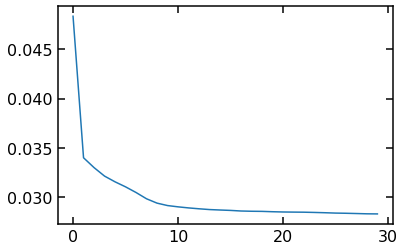

In [317]:
plt.plot(all_losses)
plt.show()

### Evaluating the trained model

In [301]:
for i in range(2):
    sample = train_size + int((test_size-1)*np.random.rand())
    with torch.no_grad():
        test_input = tensor_x[sample].unsqueeze(1)
        y_pred = model(test_input / norm_x)
        print(y_pred, tensor_y[sample] / norm_y)


tensor([[-0.2567]]) tensor([-0.3853])
tensor([[-0.2703]]) tensor([-0.1437])


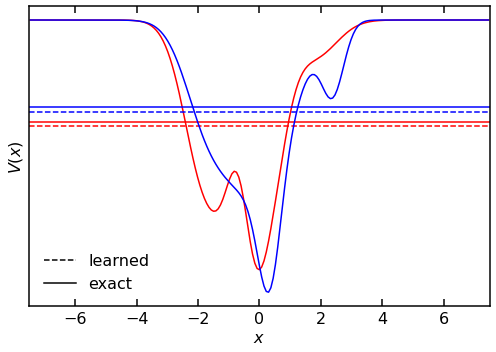

In [344]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0],linestyle='dashed', color='black'), Line2D([0], [0], color='black')]

plt.style.use('scientific.mplstyle')
fig, ax = plt.subplots(ncols=1,figsize=(7,5))

colors = ['red', 'blue', 'green']
model.float()


for i in range(2):
    sample = train_size + int((test_size-1)*np.random.rand())
    with torch.no_grad():
        test_input = tensor_x[sample].unsqueeze(1) / norm_x
        y_pred = model(test_input ).item() 

    ax.plot(ham_random.x_values, tensor_x[sample][0], color=colors[i] )
    ax.axhline(y_pred, linestyle='--', color=colors[i] )
    ax.axhline(tensor_y[sample].item() , color=colors[i] )

ax.set_yticks([])

ax.set_xlabel('$x$')

ax.set_ylabel('$V(x)$')
ax.set_xlim(-7.5,7.5)


# plt.ylim(0,10)
# plt.xlim(-8,8)
plt.tight_layout()
leg = ax.get_legend()

plt.legend(custom_lines, ['learned','exact'])

plt.show()


In [345]:
fig.savefig('learn_energy.png',dpi=fig.dpi)